## Interactive Gaussan Splat Viewer with Kaolin

We are going to show a really simple way to integrate gaussian splat rendering
with an interactive viewer in [Kaolin Library](https://github.com/NVIDIAGameWorks/kaolin).

**Interactively view your remote checkpoints in a notebook!**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision

#from tqdm import tqdm
#from os import makedirs


#from utils.general_utils import safe_state


# Gaussian splatting dependencies
from utils.system_utils import searchForMaxIteration
#from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera
#from scene import Scene

import kaolin

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load checkpoint

In [4]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False

        
def load_checkpoint(model_path, sh_degree=3, iteration=-1):
    # Find checkpoint
    checkpt_dir = os.path.join(model_path, "point_cloud")
    if iteration == -1:
        iteration = searchForMaxIteration(checkpt_dir)
    checkpt_path = os.path.join(checkpt_dir, f"iteration_{iteration}", "point_cloud.ply")
    
    # Load guassians
    gaussians = GaussianModel(sh_degree)
    gaussians.load_ply(checkpt_path)                                                 
    return gaussians

    
model_path = 'output/fa41de0a-3'
gaussians = load_checkpoint(model_path)
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")

print(gaussians)
print(dir(gaussians))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_features_dc', '_features_rest', '_opacity', '_prune_optimizer', '_rotation', '_scaling', '_xyz', 'active_sh_degree', 'add_densification_stats', 'capture', 'cat_tensors_to_optimizer', 'construct_list_of_attributes', 'covariance_activation', 'create_from_pcd', 'denom', 'densification_postfix', 'densify_and_clone', 'densify_and_prune', 'densify_and_split', 'get_covariance', 'get_features', 'get_opacity', 'get_rotation', 'get_scaling', 'get_xyz', 'inverse_opacity_activation', 'load_ply', 'max_radii2D', 'max_sh_degree', 'oneupSHdegree', 'opacity_activation', 'optimizer', 'percent_dense', 'prune_points', 'replace_tensor_to_optimizer', 'reset_opacity',

## Render and check

render: [3, 800, 800] (torch.float32)[cuda:0]  - [min 0.0000, max 0.9003, mean 0.0420] 
viewspace_points: [304003, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
visibility_filter: [304003] (torch.bool)[cuda:0]  - [min 1.0000, max 1.0000, mean 1.0000] 
radii: [304003] (torch.int32)[cuda:0]  - [min 3.0000, max 170.0000, mean 7.2842] 


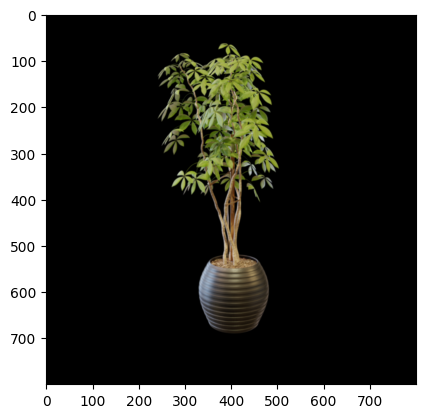

In [5]:
test_camera = GSCamera(colmap_id=0,
                       R=np.array([[-9.90378975e-01,  2.33055411e-02, -1.36404163e-01], [ 1.38380799e-01,  1.66795664e-01, -9.76232418e-01], [-1.64442514e-09, -9.85716042e-01, -1.68415955e-01]]), 
                       T=np.array([6.81594019e-09, 2.07212194e-10, 4.03112844e+00]), 
                       FoVx=0.6911112070083618, 
                       FoVy=0.6911112070083618, 
                       image=torch.zeros((3, 800, 800)),  # fake 
                       gt_alpha_mask=None,
                       image_name='fake',
                       uid=0)
render_res = render(test_camera, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

## Create Interactive Viewer

0.29999998699018754
R: [1, 3, 3] (torch.float32)[cpu]  
t: [1, 3, 1] (torch.float32)[cpu]  
orig view matrix: tensor([[-9.9038e-01,  2.3306e-02, -1.3640e-01,  0.0000e+00],
        [ 1.3838e-01,  1.6680e-01, -9.7623e-01,  0.0000e+00],
        [-1.6444e-09, -9.8572e-01, -1.6842e-01,  0.0000e+00],
        [ 6.8159e-09,  2.0721e-10,  4.0311e+00,  1.0000e+00]], device='cuda:0')
New view_matrix: tensor([[-9.9038e-01,  2.3306e-02, -1.3640e-01,  0.0000e+00],
        [ 1.3838e-01,  1.6680e-01, -9.7623e-01,  0.0000e+00],
        [-1.6444e-09, -9.8572e-01, -1.6842e-01,  0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  1.0000e+00]], device='cuda:0')
orig camera center: tensor([0.5499, 3.9353, 0.6789], device='cuda:0')
CameraExtrinsics of 1 cameras, of coordinate system: 
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]). 
Camera #0 View Matrix: 
tensor([[[-9.9038e-01,  2.3306e-02, -1.3640e-01,  0.0000e+00],
         [ 1.3838e-01,  1.6680e-01, -9.7623e-01,  0.0000e+00]

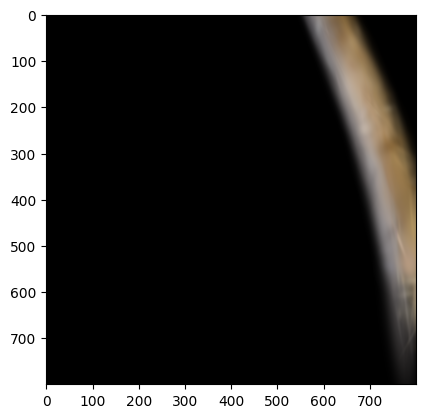

In [31]:
camera = kaolin.render.camera.Camera.from_args(
    eye=torch.tensor([1.5, 1, 2]),
    at=torch.tensor([0.0, 0.0, 0.0]),
    up=torch.tensor([0.0, 1.0, 0.0]),
    fov=0.3,  # math.pi * 20 / 180,
    width=800,
    height=800,
    device="cuda",
    dtype=torch.float32
)

def compute_cam_fov(intrinsics, axis='x'):
    # compute FOV from focal
    aspectScale = intrinsics.width / 2.0
    tanHalfAngle = aspectScale / (intrinsics.focal_x if axis == 'x' else intrinsics.focal_y).item()
    fov = np.arctan(tanHalfAngle) * 2
    return fov

print(compute_cam_fov(camera.intrinsics))

def convert_kaolin_camera(kal_camera):
    log_tensor(kal_camera.extrinsics.R, 'R')
    log_tensor(kal_camera.extrinsics.t, 't')
    return GSCamera(colmap_id=0,
                    R=kal_camera.extrinsics.R[0, ...].cpu().numpy(), 
                       T=kal_camera.extrinsics.t.squeeze().cpu().numpy(), 
                       FoVx=compute_cam_fov(kal_camera.intrinsics, 'x'), 
                       FoVy=compute_cam_fov(kal_camera.intrinsics, 'y'), 
                       image=torch.zeros((3, kal_camera.height, kal_camera.width)),  # fake 
                       gt_alpha_mask=None,
                       image_name='fake',
                       uid=0)

def convert_gs_camera(gs_camera):
    return kaolin.render.camera.Camera(
        kaolin.render.camera.CameraExtrinsics.from_view_matrix(gs_camera.world_view_transform, device='cpu'),
        kaolin.render.camera.intrinsics_pinhole.PinholeIntrinsics.from_fov(
            width=gs_camera.image_width, height=gs_camera.image_height, fov=gs_camera.FoVx, device='cpu'))

kal_cam = convert_gs_camera(test_camera)
test_cam_back = convert_kaolin_camera(kal_cam)

print(f'orig view matrix: {test_camera.world_view_transform}')
print(f'New view_matrix: {test_cam_back.world_view_transform}')
print(f'orig camera center: {test_camera.camera_center}')
print(kal_cam.extrinsics)

print(f'Original T: {test_camera.T}')
print(f'New T: {test_cam_back.T}')



render_res = render(test_cam_back, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())
    

In [23]:
def render_kaolin(kaolin_cam):
    render_res = render(convert_kaolin_camera(kaolin_cam), gaussians, pipeline, background)
    rendering = render_res["render"]
    return (rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu()

visualizer = kaolin.visualize.IpyTurntableVisualizer(
    512, 512, camera, render_kaolin,
    max_fps=24, world_up_axis=1)
visualizer.show()

R: [1, 3, 3] (torch.float32)[cuda:0]  
t: [1, 3, 1] (torch.float32)[cuda:0]  


Canvas(height=512, width=512)

Output()